## Table of Contents
* [Load models and data](#Load-models-and-data)
* [Table errors](#Errors)
* [Boxplot residuals](#Boxplot-residuals)
* [Permutation plots](#Permutation-plots)
* [Predicted vs measured plots](#Predicted-vs-measured-plots)
* [Regression with ratio](#Regression-with-ratio)

In [2]:
from ml import models
from ml import data_load
import os
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from ml import Py4R_plots

# os.listdir(data_load.PATH_TO_MODELS_SYKE)

## Load models and data

In [3]:
skdata_X_train, skdata_X_test, skdata_y_train, skdata_y_test = data_load.load_SYKE()
mean_y_train = np.mean(skdata_y_train)

In [4]:
modelos = {}
table_preds = {}
for bands_name in data_load.bands_try_SYKE:
    for model in models.ALL_NAME_MODELS:
        file_model = os.path.join(data_load.PATH_TO_MODELS_SYKE,
                                  model+'_'+bands_name+'.pkl')
        if not os.path.exists(file_model):
            print("File %s does not exist"%file_model)
            continue
        
        print("Loading model & make test preds from file %s"%file_model)
        
        regressor_sklearn = joblib.load(file_model)
        modelos[model+"_"+bands_name] =regressor_sklearn 

        table_preds[model+"_"+bands_name] = regressor_sklearn.predict(skdata_X_test[data_load.bands_try_SYKE[bands_name]])+mean_y_train

table_preds = pd.DataFrame(table_preds)

Loading model & make test preds from file /media/disk/databases/SYKE/models/RLR_S2bands.pkl
Loading model & make test preds from file /media/disk/databases/SYKE/models/RFR_S2bands.pkl
Loading model & make test preds from file /media/disk/databases/SYKE/models/KRR_S2bands.pkl
Loading model & make test preds from file /media/disk/databases/SYKE/models/SVR_S2bands.pkl
Loading model & make test preds from file /media/disk/databases/SYKE/models/GPR_S2bands.pkl
File /media/disk/databases/SYKE/models/Polyfit_S2bands.pkl does not exist
Loading model & make test preds from file /media/disk/databases/SYKE/models/RLR_S2ratio1.pkl
Loading model & make test preds from file /media/disk/databases/SYKE/models/RFR_S2ratio1.pkl
Loading model & make test preds from file /media/disk/databases/SYKE/models/KRR_S2ratio1.pkl
Loading model & make test preds from file /media/disk/databases/SYKE/models/SVR_S2ratio1.pkl
Loading model & make test preds from file /media/disk/databases/SYKE/models/GPR_S2ratio1.pkl
L

## Errors
[Table of Contents](#Table-of-Contents)

In [5]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
bands_ordered = ['S2ratio1','S2ratio2', 'ratios_S2','S2bands', 'S2bands&ratios', 
               'S3ratio1', 'S3ratio2', 'ratios_S3','S3bands','S3bands&ratios']
datos = []

def pearson(y_true,y_pred):
    val,_ = pearsonr(y_true,y_pred)
    return val

def root_mean_squared_error(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

def rmse_rel(y_true,y_pred):
    return np.sqrt(np.mean(((y_pred - y_true) / y_true) ** 2))

def bias(y_true,y_pred):
    return np.mean(y_pred - y_true)
    
metrics = [r2_score,bias, mean_absolute_error,pearson,
           root_mean_squared_error,rmse_rel ]

for b in bands_ordered:
    for m in models.ALL_NAME_MODELS:
        dato = {"model":m,"band":b}
        for metric in metrics:
            if m+"_"+b in table_preds:
                dato[metric.__name__] = metric(skdata_y_test,table_preds[m+"_"+b].values)
        if len(dato.keys())>2:
            datos.append(dato)
            
datos = pd.DataFrame(datos)  
datos.set_index(["band","model"])[[m.__name__ for m in metrics]]

r2_score      bias  mean_absolute_error   pearson  \
band           model                                                        
S2ratio1       RLR      0.886949  0.065663             1.747292  0.941827   
               RFR      0.895748 -0.038802             1.333702  0.946683   
               KRR      0.933478  0.005385             1.052230  0.966269   
               SVR      0.928378 -0.280937             1.026451  0.965778   
               GPR      0.933610  0.013684             1.057280  0.966286   
               Polyfit  0.933770  0.004629             1.067932  0.966476   
S2ratio2       RLR      0.948773  0.026268             1.142602  0.974057   
               RFR      0.949353 -0.038590             1.133293  0.974404   
               KRR      0.966804 -0.004675             0.916385  0.983274   
               SVR      0.964651  0.224556             0.893316  0.982570   
               GPR      0.966727 -0.004364             0.916171  0.983236   
               Polyfit  0.965989 -0.000783             0.917250  0.982865   
ratios_S2      RLR      0.948775  0.026413             1.145317  0.974056   
               RFR      0.968881 -0.018209             0.789342  0.984334   
               KRR      0.973748  0.010204             0.750688  0.986819   
               SVR      0.974174  0.064493             0.745137  0.987041   
               GPR      0.971570 -0.005205             0.748408  0.985689   
S2bands        RLR      0.484017  0.124541             3.957541  0.696344   
               RFR      0.978012 -0.052520             0.296347  0.989791   
               KRR      0.996617  0.000424             0.255062  0.998307   
               SVR      0.991219 -0.005989             0.089521  0.995669   
               GPR      0.998369 -0.003497             0.025699  0.999189   
S2bands&ratios RLR      0.986726  0.016334             0.620176  0.993350   
               RFR      0.996951 -0.008638             0.148158  0.998478   
               KRR      0.996454  0.013508             0.041467  0.998235   
               SVR      0.999486 -0.007925             0.043356  0.999747   
               GPR      0.998945  0.011536             0.017297  0.999474   
S3ratio1       RLR      0.891408  0.063662             1.710737  0.944188   
               RFR      0.901898  0.023499             1.318878  0.950302   
               KRR      0.936247  0.005375             1.032827  0.967694   
               SVR      0.931744 -0.254394             1.010171  0.967214   
               GPR      0.936352  0.013225             1.037536  0.967701   
               Polyfit  0.936496  0.004603             1.048339  0.967880   
S3ratio2       RLR      0.947906  0.015043             1.138837  0.973606   
               RFR      0.933529 -0.049919             1.225821  0.966315   
               KRR      0.960072 -0.010085             0.995695  0.979842   
               SVR      0.957811  0.264536             0.967354  0.979287   
               GPR      0.960104 -0.009761             0.995761  0.979857   
               Polyfit  0.959427 -0.006550             0.994722  0.979514   
ratios_S3      RLR      0.949354  0.023819             1.130254  0.974353   
               RFR      0.968695 -0.034515             0.795411  0.984232   
               KRR      0.973246  0.007587             0.750587  0.986565   
               SVR      0.974409  0.072053             0.748132  0.987163   
               GPR      0.955930 -0.052678             0.800649  0.977884   
S3bands        RLR      0.580171  0.035920             3.100724  0.763240   
               RFR      0.981659 -0.046923             0.251642  0.991500   
               KRR      0.998271  0.010293             0.174307  0.999137   
               SVR      0.994056 -0.018537             0.114003  0.997148   
               GPR      0.998584 -0.000592             0.028577  0.999295   
S3bands&ratios RLR      0.991111  0.005680             0.472063  0.995546   
               RFR  

## Boxplot residuals
[Table of Contents](#Table-of-Contents)

In [6]:
table_residuals = table_preds.copy()

for c in table_preds.columns:
    table_residuals[c] = table_preds[c] - skdata_y_test

table_residuals = pd.melt(table_residuals,var_name="model_band")
table_residuals["model"] = table_residuals["model_band"].apply(lambda x: x.split("_")[0])
table_residuals["band"] = table_residuals["model_band"].apply(lambda x: "_".join(x.split("_")[1:]))
table_residuals.head()


,model_band,value,model,band
0,GPR_S2bands,0.000492,GPR,S2bands
1,GPR_S2bands,0.000441,GPR,S2bands
2,GPR_S2bands,0.000354,GPR,S2bands
3,GPR_S2bands,-0.000066,GPR,S2bands
4,GPR_S2bands,-0.000857,GPR,S2bands


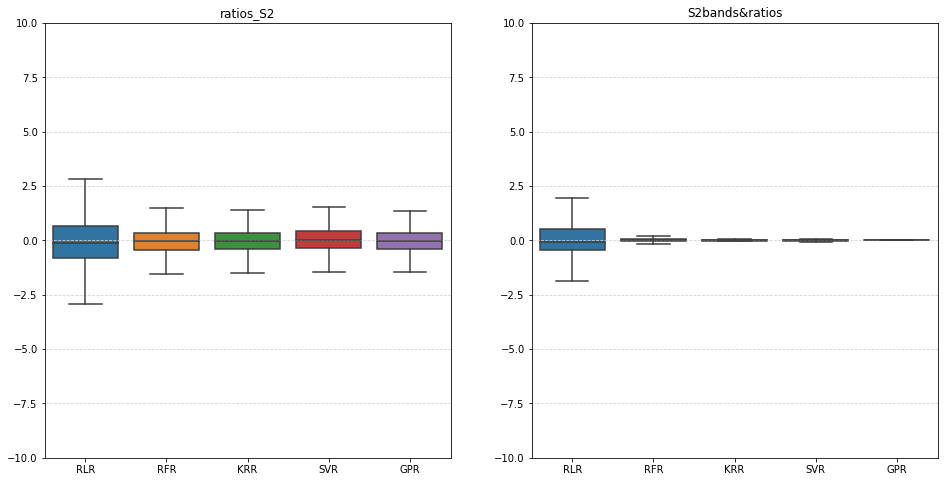

In [7]:
fig,axs = plt.subplots(1,2,figsize=(16,8))

for ax,lab in zip(axs,["ratios_S2","S2bands&ratios"]):
    sns.boxplot(x="model",y="value",data=table_residuals[table_residuals["band"] == lab],
                order=[m for m in models.ALL_NAME_MODELS if m != "Polyfit"],ax=ax,fliersize=0)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(lab)
    ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    ax.set_ylim(-10,10)


## Permutation plots
[Table of Contents](#Table-of-Contents)

In [8]:
sal = []
for m in ['RLR', 'RFR', 'KRR', 'SVR', 'GPR']:
    for b in ["S2bands","S2bands&ratios"]:
        model = m+"_"+b
        sal_ = Py4R_plots.permutation_test( modelos[model],
                                  skdata_X_test[data_load.bands_try_SYKE[b]], 
                                  skdata_y_test-mean_y_train)
        sal_["band"] = b
        sal_["model"] = m
        sal.append(sal_)

sal = pd.concat(sal,axis=0)
sal.head()

,variable,mean_absolute_error,band,model
0,S2443,5.264737,S2bands,RLR
1,S2443,5.308086,S2bands,RLR
2,S2443,5.227422,S2bands,RLR
3,S2443,5.062395,S2bands,RLR
4,S2443,5.296285,S2bands,RLR


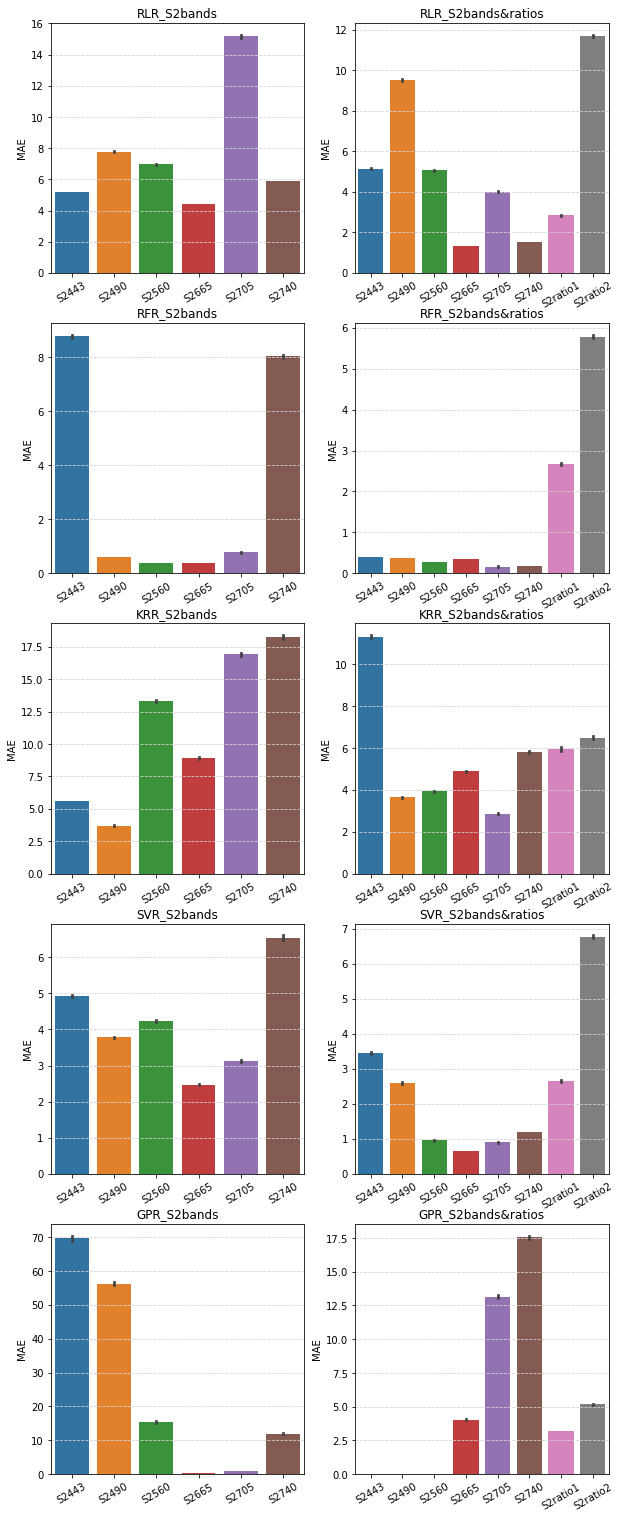

In [9]:
fig,axs = plt.subplots(5,2,figsize=(10,32))
axs = axs.flatten()
for ax,model in zip(axs,[m+"_"+b for m in ['RLR', 'RFR', 'KRR', 'SVR', 'GPR'] for b in ["S2bands","S2bands&ratios"]]):
    b = model.split("_")[1]
    m = model.split("_")[0]
    sns.barplot(x="variable", y="mean_absolute_error", data=sal[(sal["band"] == b) & (sal["model"] == m)],
                ax=ax)
    ax.yaxis.grid(color='lightgrey', linestyle='dashed')
    ax.patch.set_facecolor('white')
    ax.set_ylabel("MAE")
    ax.set_xlabel("")
    ax.set_title(model)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

plt.subplots_adjust(bottom=0.25)

## Predicted vs measured plots
[Table of Contents](#Table-of-Contents)

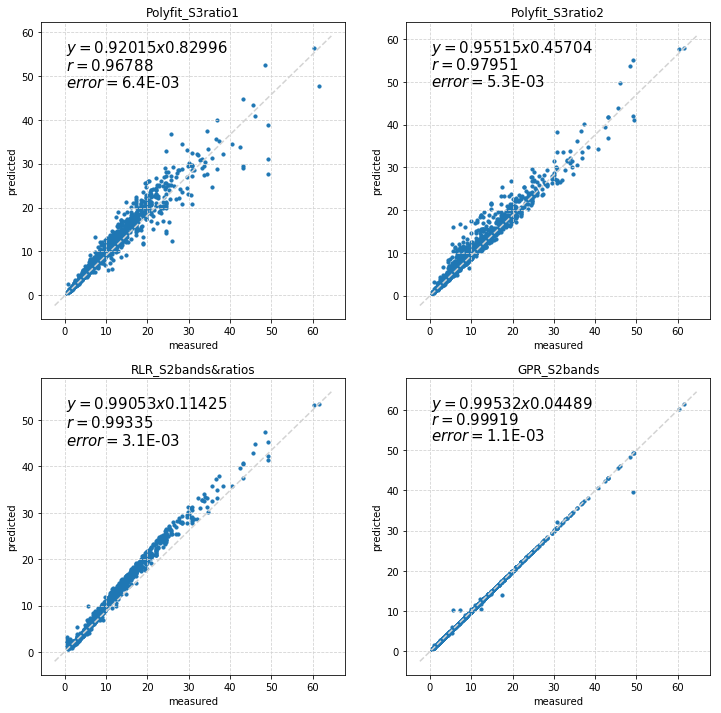

In [10]:
fig,axs = plt.subplots(2,2,figsize=(12,12))

axs = axs.flatten()
for ax,model in zip(axs,["Polyfit_S3ratio1","Polyfit_S3ratio2","RLR_S2bands&ratios","GPR_S2bands"]):
    Py4R_plots.correlative_plot(table_preds[model],skdata_y_test,ax=ax)
    ax.set_title(model)

## Regression with ratio
[Table of Contents](#Table-of-Contents)

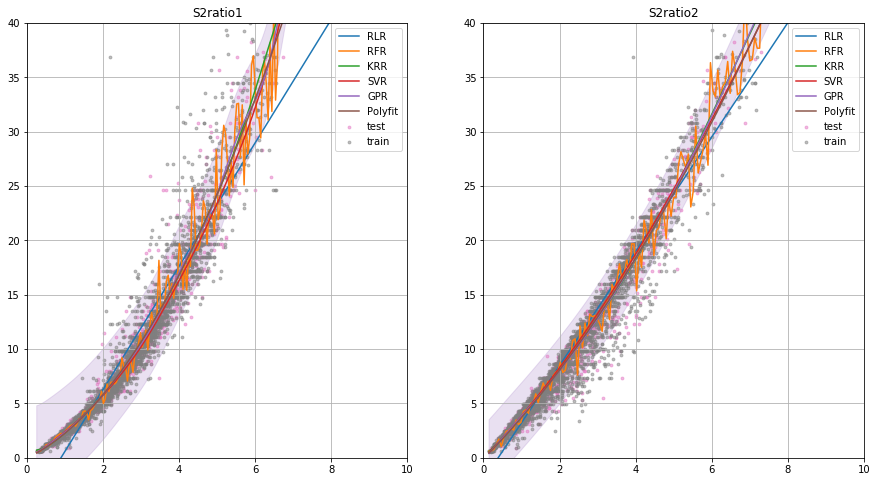

In [11]:
fig,axs = plt.subplots(1,2,figsize=(15,8))

for ratio,ax in zip(["S2ratio1","S2ratio2"],axs):
    X_test = skdata_X_test[data_load.bands_try_SYKE[ratio][0]].values
    X_train = skdata_X_train[data_load.bands_try_SYKE[ratio][0]].values
    
    models_predict = [(m,modelos[m+"_"+ratio]) for m in models.ALL_NAME_MODELS]
    Py4R_plots.regression_plot(X_train,X_test,skdata_y_train,
                               skdata_y_test,models_predict,mean_y_train,ax=ax)
    ax.set_title(ratio)
    ax.set_xlim(0,10)
    ax.set_ylim(0,40)
    ax.grid()
    ax.legend()